# Fitting single PSFs in 2D, example 1

* Simulated PSF based on 2D Gaussian function with mixed Poisson-Gaussian noise 
* CNN-based encoder to extract x, y, amplitude, background, Gaussian sigma
* Rendered back into images using 2D Gaussian function

In [1]:
import os
import numpy as np
from matplotlib import pyplot

import torch
from torch import nn
from torch.utils.data import DataLoader

from torchinfo import summary

from smlm_dl import dataset, model, trainer, config, util

/gpfs/ysm/home/kkc29/repos/smlm-dl/smlm_dl/dataset.py:441: RuntimeWarning: invalid value encountered in log
  im = axes[1].imshow(np.log(tiled_images))


1361:	 [id = 1361.000,], [A = 1678.130,], [bg = 60.805,], [x = -1.820,], [y = -4.367,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
1705:	 [id = 1705.000,], [A = 1925.640,], [bg = 73.078,], [x = 6.307,], [y = -4.980,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
903:	 [id = 903.000,], [A = 1870.721,], [bg = 95.242,], [x = -0.125,], [y = 11.398,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
1030:	 [id = 1030.000,], [A = 1009.664,], [bg = 35.859,], [x = 11.686,], [y = -4.758,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
621:	 [id = 621.000,], [A = 632.286,], [bg = 59.342,], [x = -5.571,], [y = 1.322,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
263:	 [id = 263.000,], [A = 1717.842,], [bg = 23.459,], [x = -4.685,], [y = -2.689,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
1036:	 [id = 1036.000,], [A = 1620.299,], [bg = 21.430,], [x = 6.217,], [y = -5.058,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
862:	 [id = 862.000,], [A = 979.612,], [bg =

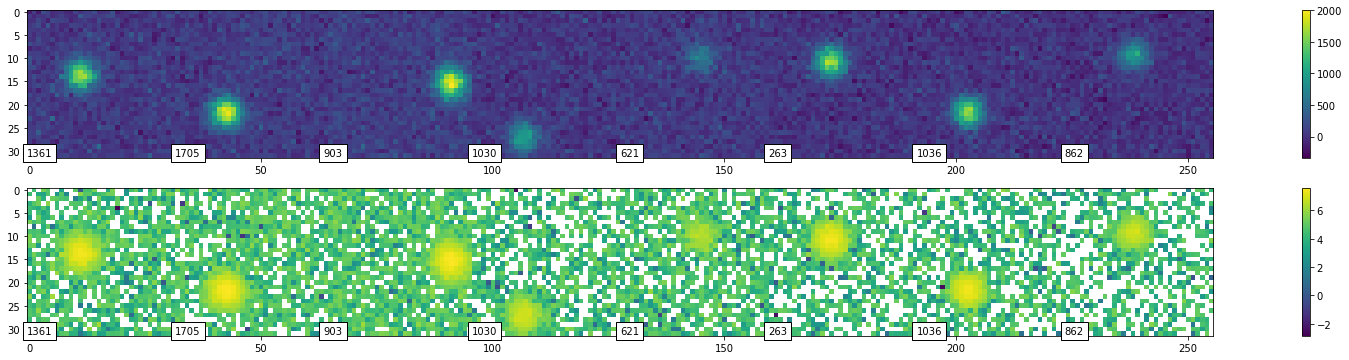

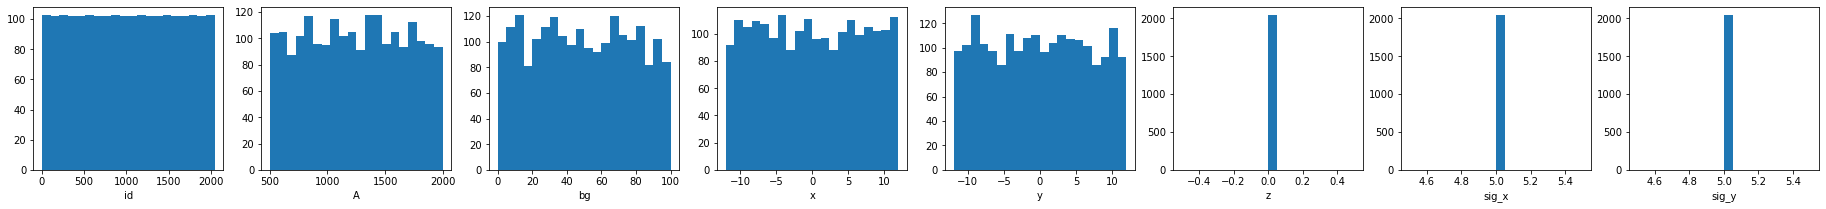

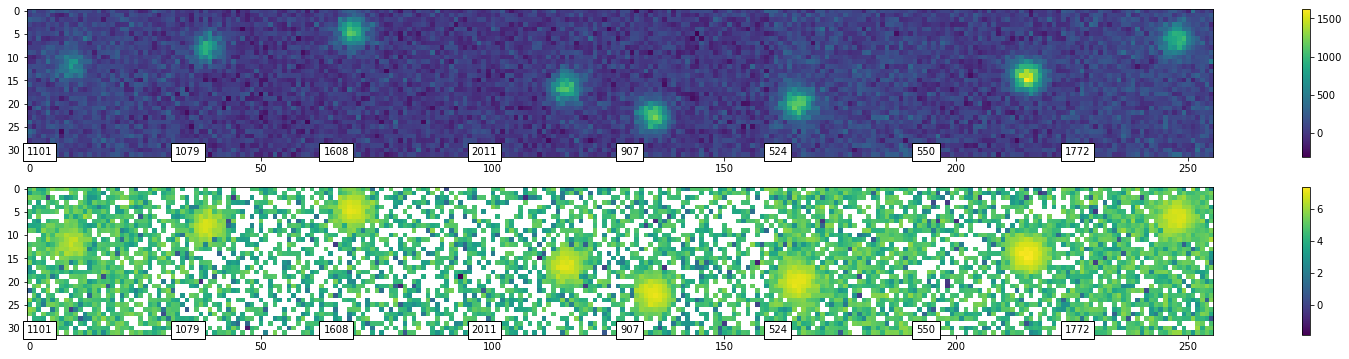

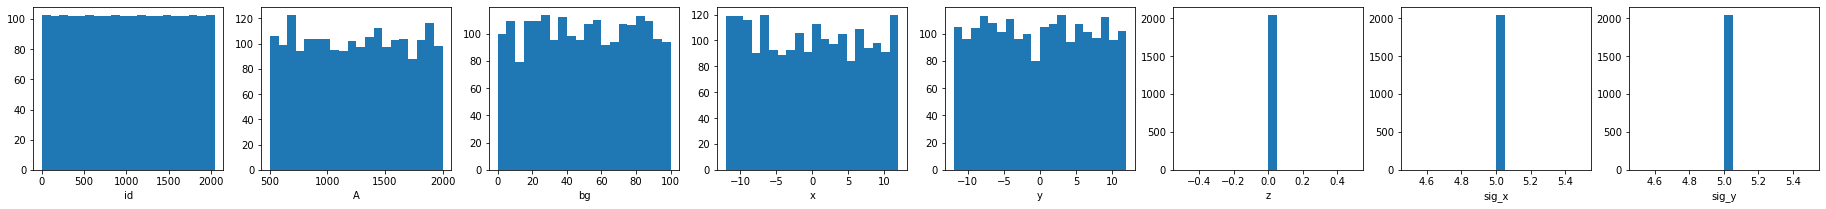

In [2]:
settings = {
    'out_size': (32,32),
    'length': (2048, 1),
    'psf_params': {'A': [500, 2000],
                   'bg': [0, 100],
                   'x': [-12, 12],
                   'y': [-12, 12],
                   'z': [0, 0]
                  },
}

training_data = dataset.Gaussian2DPSFDataset(**settings)
training_data.to('cuda')
dataset.inspect_images(training_data)
train_dataloader = DataLoader(training_data, batch_size=2048, shuffle=True, )

validation_data = dataset.Gaussian2DPSFDataset(**settings)
validation_data.to('cuda')
dataset.inspect_images(validation_data)
validation_dataloader = DataLoader(validation_data, batch_size=2048, shuffle=True, )

In [3]:
fitting_model = model.Gaussian2DModel(fit_params=['x','y','A','bg','sig'], encoder_params={'depth':3})

print(summary(fitting_model, depth=4))

Layer (type:depth-idx)                   Param #
Gaussian2DModel                          --
├─DirectMapperModel: 1-1                 --
│    └─ModuleDict: 2-1                   --
├─Gaussian2DRenderer: 1-2                --
├─ConvImageEncoderModel: 1-3             --
│    └─ModuleDict: 2-2                   --
│    │    └─Sequential: 3-1              --
│    │    │    └─Identity: 4-1           --
│    │    │    └─Conv2d: 4-2             320
│    │    │    └─ReLU: 4-3               --
│    │    │    └─Identity: 4-4           --
│    │    │    └─Conv2d: 4-5             9,248
│    │    │    └─ReLU: 4-6               --
│    │    │    └─MaxPool2d: 4-7          --
│    │    └─Sequential: 3-2              --
│    │    │    └─Identity: 4-8           --
│    │    │    └─Conv2d: 4-9             18,496
│    │    │    └─ReLU: 4-10              --
│    │    │    └─Identity: 4-11          --
│    │    │    └─Conv2d: 4-12            36,928
│    │    │    └─ReLU: 4-13              --
│    │    │    

Device: cuda
Saved model to : /home/kkc29/scratch60/runs/2022-04-29_18-28-48_c18n07.farnam.hpc.yale.internal/model.ptm
Saved loss model : /home/kkc29/scratch60/runs/2022-04-29_18-28-48_c18n07.farnam.hpc.yale.internal/loss.ptm


  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 999. Saved to : /home/kkc29/scratch60/runs/2022-04-29_18-28-48_c18n07.farnam.hpc.yale.internal/checkpoint.ptc
input shape: (2048, 1, 32, 32), output_shape: (2048, 1, 32, 32)


/gpfs/ysm/home/kkc29/repos/smlm-dl/smlm_dl/model/base.py:151: RuntimeWarning: invalid value encountered in log10
  im = axes[0, i].imshow(np.log10(img))


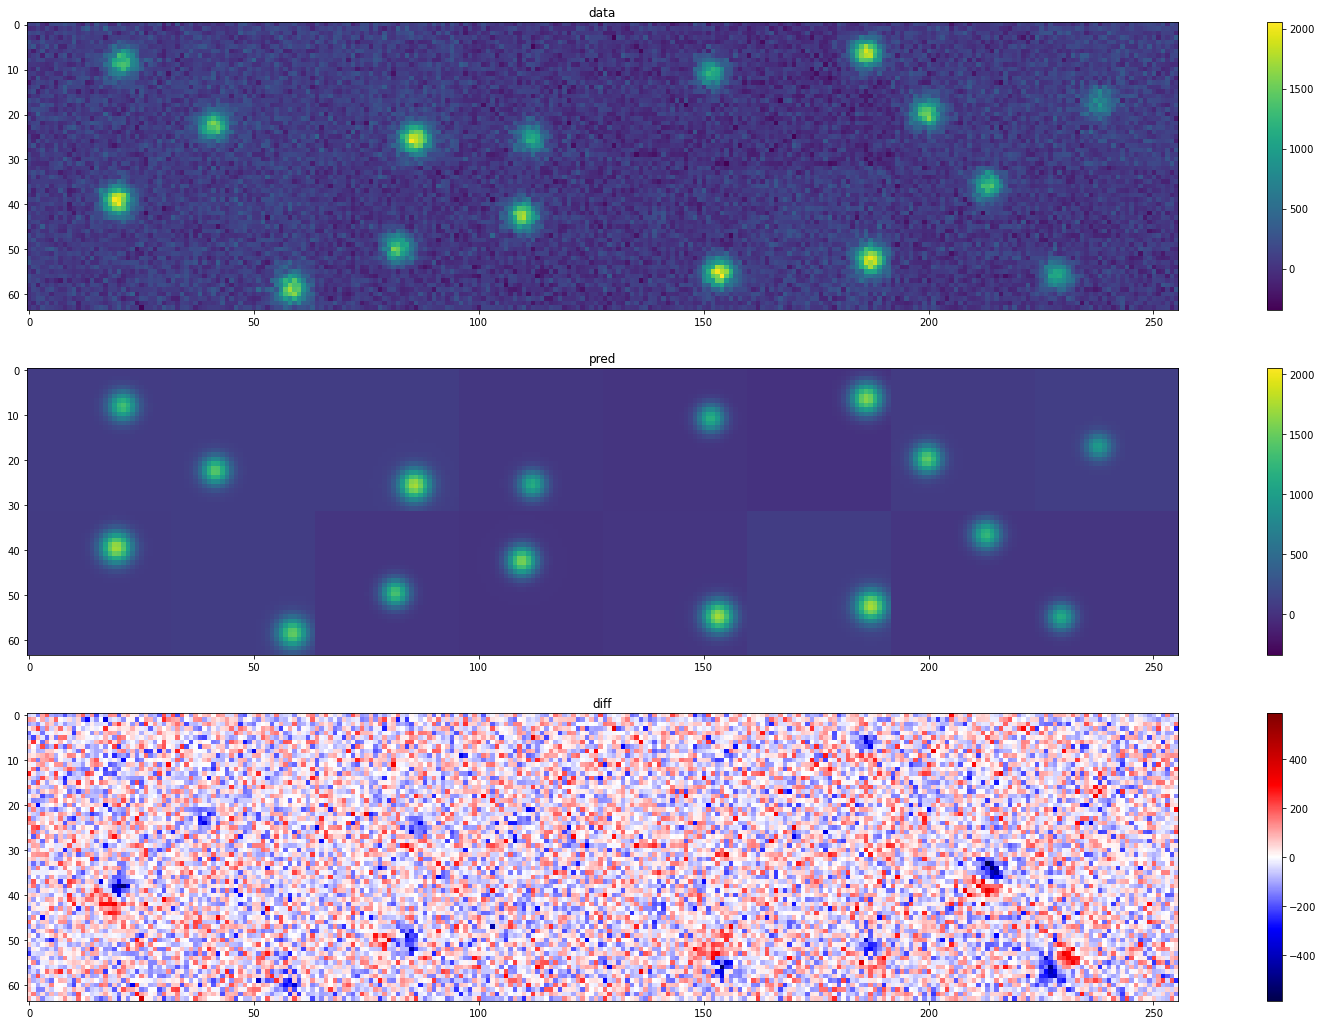

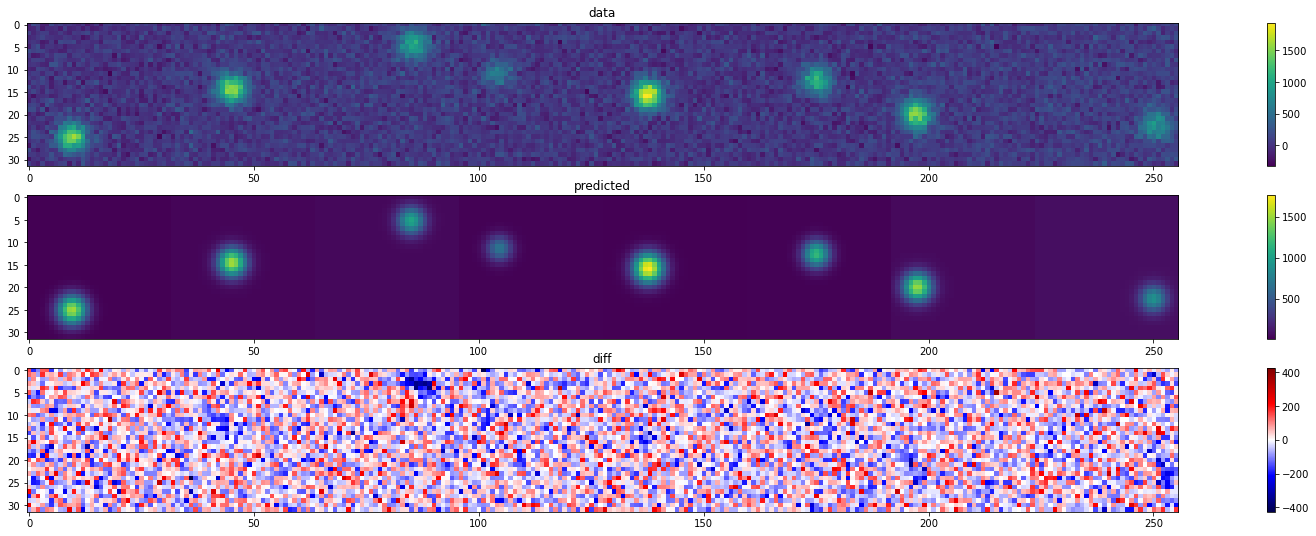

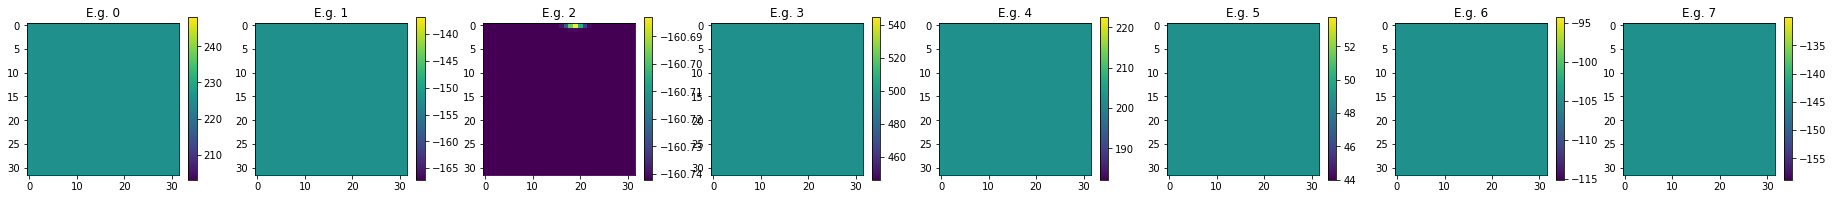

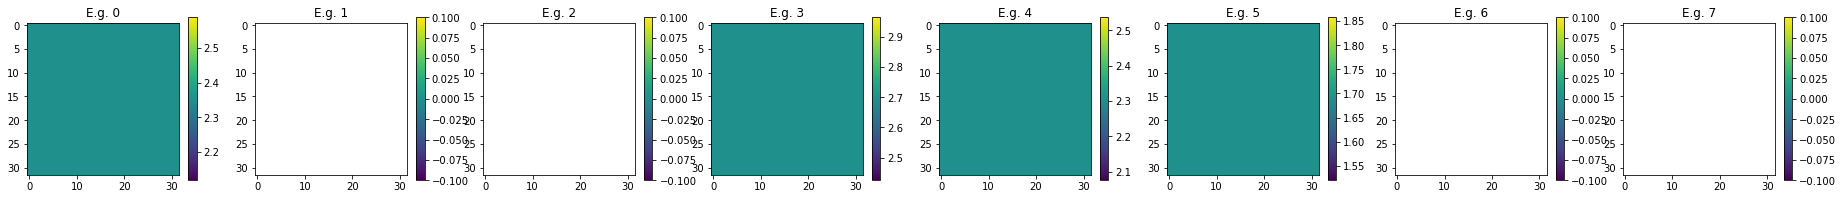

In [4]:
dict_log = {}
training = trainer.FittingTrainer(fitting_model, train_dataloader, validation_dataloader,)
training.train_and_validate(1000, 10, 100, tb_logger=True, dict_log=dict_log)
model.check_model(fitting_model, train_dataloader)

/gpfs/ysm/home/kkc29/repos/smlm-dl/smlm_dl/trainer.py:432: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i].set_yscale("log")
/gpfs/ysm/home/kkc29/repos/smlm-dl/smlm_dl/trainer.py:432: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i].set_yscale("log")


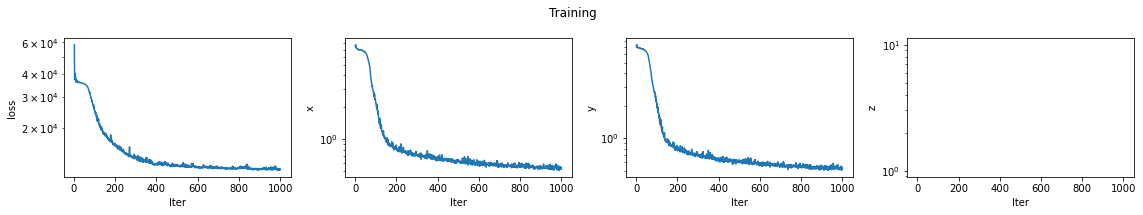

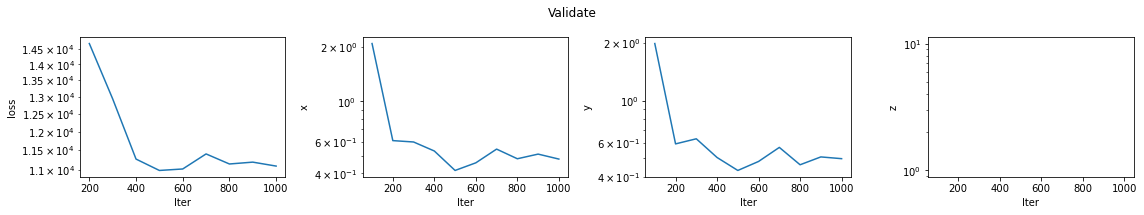

In [5]:
plots = trainer.inspect_dict_log(dict_log, log=True)